In [1]:
from pyincore import InsecureIncoreClient, DataService, InventoryDataset
from pyincore import HazardService
from pyincore import PlotUtil
import json
import time
import geopandas as gpd
from matplotlib import cm
import pandas as pd
import numpy as np

In [2]:
client = InsecureIncoreClient("http://incore2-services.ncsa.illinois.edu:8888", "jonglee")

# Data Service Module 
A python module to communicate IN-CORE data service
- query/search dataset
- download dataset
- upload dataset

In [3]:
#Initialize data service
datasvc = DataService(client)

In [4]:
#Sample dataset: 5ade51daec2309045650c157 (Shelby county essential facility)
#Download the dataset 
dataset_id = "5ade51daec2309045650c157"
ess_dataset = datasvc.get_dataset_metadata(dataset_id)
ess = datasvc.get_dataset_blob(ess_dataset['id'])

It already exsists; no unzip


In [5]:
buildings = InventoryDataset(ess)

# Explore the building inventory with GeoPandas
## GeoPandas is geospatial data analysis tool and library

In [8]:
gdf = gpd.GeoDataFrame.from_features(buildings.inventory_set)

In [9]:
gdf.head()

,IMPUTED,a_stories,appr_bldg,b_stories,bldg_id,broad_occ,bsmt_type,cont_val,dgn_lvl,dwell_unit,...,parid,parid_card,repl_cst,sq_foot,str_cst,str_prob,str_typ2,struct_typ,tract_id,year_built
0,F,1,1015500,0,088012 00133C_1_1,Office Commercial,NONE,3492254,Moderate - Code,0,...,088012 00133C,088012 00133C_1,2328169,19592,395789,1.00000,S1L,S1,47157020621,1997
1,T,2,3375000,0,071025 00085_SCH534,Education,NONE,8860365,Low - Code,0,...,071025 00085,071025 00085_SCH534,8860365,75000,2197371,0.46050,C1L,C1,47157010000,1965
2,F,2,171300,0,017022 00015_1_1,Office Commercial,NONE,1008905,Low - Code,1,...,017022 00015,017022 00015_1,672604,4388,98200,0.35000,W1,W1,47157003600,1900
3,T,2,3375000,0,044042 00008C_SCH576,Education,NONE,8860365,Low - Code,0,...,044042 00008C,044042 00008C_SCH576,8860365,75000,2197371,0.46050,C1L,C1,47157003000,1965
4,T,1,804000,2,075150 00025_1_1,Education,SLAB,2435338,Low - Code,0,...,075150 00025,075150 00025_1,2435338,20100,603964,0.41281,C1L,C1,47157022330,1965


## Group by broad occupancy type 

In [10]:
a = gdf['broad_occ'].value_counts()
a

Office Commercial    406
Education            295
Health Care           22
Name: broad_occ, dtype: int64

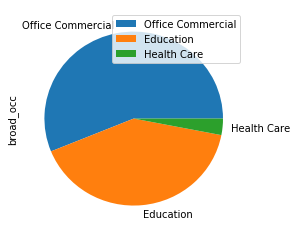

In [11]:
a.plot.pie(figsize=(4,4), legend=True)

## Group by structure type

In [12]:
a = gdf['str_typ2'].value_counts()
a

C1L     348
S1L     121
W1       91
W2       70
URML     41
C2M      11
S1M      10
RM1L     10
PC1       6
C2H       6
S1H       4
S3        3
C1M       2
Name: str_typ2, dtype: int64

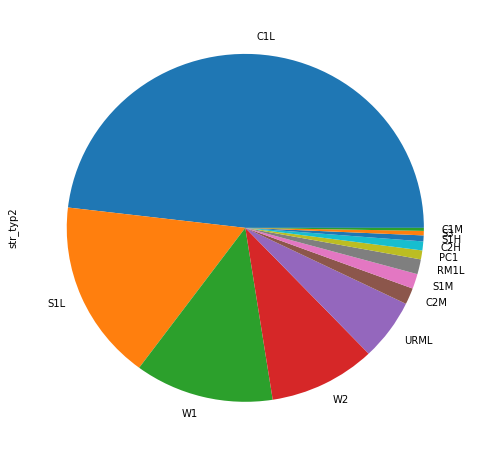

In [14]:
a.plot.pie(figsize=(8,8))

## Plot data on open street map

In [16]:
PlotUtil.get_geopandas_map(gdf)

## Plot data with Geospatial visualization service on open street map

In [17]:
layers = [{'id': dataset_id,'name': 'Essential Facilities', 'style':''}]
PlotUtil.get_wms_map(layers)

In [18]:
hazardsvc = HazardService(client)

## Visualize the scenario tornado and building inventory

In [20]:
layers = [
    {'id': eq['rasterDatasetId'],'name': 'earthquake', 'style':'earthquake-pga-g'},
    {'id': dataset_id,'name': 'Essential Facilities', 'style':''}
]
PlotUtil.get_wms_map(layers)

# Running Buliding Damage Analysis with the scenario tornado

In [23]:
damage_ratio_id = "5a284f2ec7d30d13bc08209a"
dmg_ratio = datasvc.get_dataset_blob(damage_ratio_id)

It already exsists; no unzip


In [24]:
from pyincore.analyses.buildingdamage import BuildingDamage

In [28]:
# Using pre-defined tornado from previous demo
tornado = {'id': '5ae92e6bec23093994d26543',
 'tornadoModel': 'MeanWidthTornado',
 'numSimulations': 1,
 'tornadoParameters': {'efRating': 'EF5',
  'maxWindSpeed': 250.0,
  'startLatitude': 35.092,
  'startLongitude': -90.091,
  'randomSeed': 1234,
  'windSpeedMethod': 1,
  'endLatitude': [35.268],
  'endLongitude': [-89.758]},
 'tornadoWidth': [815.9980909090909],
 'efBoxes': [{'efBoxWidths': [0.001002256638187928,
    0.0017328393158413994,
    0.0022321320000668874,
    0.0027387672237662794,
    0.003205018480359198,
    0.003671269736952117]}],
 'tornadoDatasetId': '5ae92e6bec230939943dde4a',
 'privileges': {'userPrivileges': {'jonglee': 'ADMIN'}, 'groupPrivileges': {}}}

In [32]:
## Visualize tornado path with building inventory

In [31]:
layers = [
    {'id': tornado['tornadoDatasetId'],'name': 'tornado', 'style':'tornado1'},
    {'id': dataset_id,'name': 'Essential Facilities', 'style':''}
]
PlotUtil.get_wms_map(layers)

In [34]:
tornado_mapping_id = "5ae0e51fff771b3240b6cce6"
bldgDmg_tornado = BuildingDamage(client, "tornado/"+tornado['id'], dmg_ratio)

In [37]:
start = time.time()
bldgDmg_tornado.get_damage(buildings.inventory_set, tornado_mapping_id, 2, None, 20)
end = time.time()
print(str(end - start)+ " sec")

2.1700799465179443 sec


## Explore output data with Pandas

In [39]:
df = pd.read_csv(output)

### Show top 5 buildings with highest mean damage

In [40]:
#show top 5 highest mean damage
df.sort_values(by=['meandamage'],ascending=False).head()

,guid,immocc,lifesfty,collprev,insignific,moderate,heavy,complete,meandamage,mdamagedev,hazardtype,hazardval
540,0baa5126-68b7-4e32-9134-8f6c25346f2d,1.000000,1.000000,0.999992,0.000000e+00,7.771561e-16,0.000008,0.999992,0.899997,0.040014,wind,109.046942
445,a234237f-094d-4c45-b303-1d2669ceef29,1.000000,1.000000,0.979352,4.254475e-10,7.618632e-08,0.020648,0.979352,0.892773,0.065197,wind,83.085011
595,d1bbca6d-cda4-47e3-9eca-fcfe987e8560,0.999999,0.999918,0.790019,8.385161e-07,8.151332e-05,0.209899,0.790019,0.826474,0.153999,wind,71.648937
489,ca8c01dc-5dd9-4f56-8dd7-354c540658ce,1.000000,0.999553,0.732441,3.489137e-07,4.462905e-04,0.267112,0.732441,0.806178,0.167365,wind,71.552831
624,0e242301-f2e2-45a4-a3a1-ca258d67671f,1.000000,0.999468,0.721908,4.392502e-07,5.313125e-04,0.277560,0.721908,0.802458,0.169453,wind,71.168347


### Filter out buildings with hazard value = 0 (buildings on the tornado path)

In [42]:
# buildings with hazard values
a =df.loc[df['hazardval'] != 0.0]
a.shape

(28, 12)

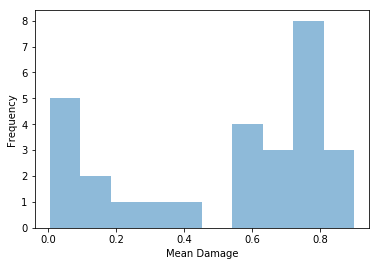

In [43]:
# Histogram of mean damages
axplot = a['meandamage'].plot.hist(alpha=0.5, x="Mean Damage")
axplot.set_xlabel("Mean Damage")
axplot

### Join output table with building inventory (geospatial data)

In [44]:
# joing result table with buliding inventory
join_gdf = gdf.merge(df, on='guid')

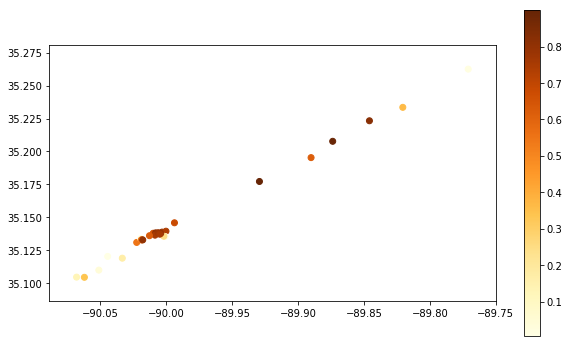

In [45]:
on_path = join_gdf.loc[join_gdf['hazardval'] != 0]
on_path.plot(figsize=(10,6), column='meandamage', cmap=cm.get_cmap("YlOrBr"), legend=True)

In [50]:
# sorted by mean damage decending order
on_path.sort_values(by=['meandamage'],ascending=False).head(n=10)

,IMPUTED,a_stories,appr_bldg,b_stories,bldg_id,broad_occ,bsmt_type,cont_val,dgn_lvl,dwell_unit,...,lifesfty,collprev,insignific,moderate,heavy,complete,meandamage,mdamagedev,hazardtype,hazardval
540,T,2,3375000,0,053037 00005_UNI560,Education,NONE,13290548,Low - Code,0,...,1.000000,0.999992,0.000000e+00,7.771561e-16,0.000008,0.999992,0.899997,0.040014,wind,109.046942
445,T,2,3375000,0,B0156 00242_SCH550,Education,NONE,8860365,Low - Code,0,...,1.000000,0.979352,4.254475e-10,7.618632e-08,0.020648,0.979352,0.892773,0.065197,wind,83.085011
595,T,2,3375000,0,B0157 00359_SCH540,Education,NONE,8860365,Low - Code,0,...,0.999918,0.790019,8.385161e-07,8.151332e-05,0.209899,0.790019,0.826474,0.153999,wind,71.648937
489,F,2,123100,0,017031 00030_1_1,Office Commercial,NONE,978510,Low - Code,0,...,0.999553,0.732441,3.489137e-07,4.462905e-04,0.267112,0.732441,0.806178,0.167365,wind,71.552831
624,F,2,166000,0,016005 00007_1_1,Office Commercial,NONE,1532960,Pre - Code,0,...,0.999468,0.721908,4.392502e-07,5.313125e-04,0.277560,0.721908,0.802458,0.169453,wind,71.168347
649,F,1,55400,0,017042 00003_1_1,Office Commercial,NONE,329570,Low - Code,0,...,0.999158,0.692468,8.104711e-07,8.416770e-04,0.306689,0.692468,0.792031,0.174807,wind,70.139492
225,F,1,989400,1,017044 00068C_1_1,Office Commercial,COMMERCIAL BSMT,3815606,Low - Code,0,...,0.999065,0.685458,9.321336e-07,9.341340e-04,0.313607,0.685458,0.789541,0.175985,wind,69.903301
567,F,1,138200,0,017038 00038C_1_1,Office Commercial,NONE,738202,Low - Code,0,...,0.998657,0.660117,1.519913e-06,1.341415e-03,0.338540,0.660117,0.780510,0.179959,wind,69.073644
533,F,1,592200,0,017028 00002C_1_1,Office Commercial,NONE,2902720,Low - Code,0,...,0.996911,0.595734,4.786039e-06,3.084679e-03,0.401176,0.595734,0.757286,0.188330,wind,67.100701
655,F,1,47500,0,017042 00015C_1_1,Office Commercial,NONE,621194,Low - Code,0,...,0.996901,0.595470,4.807531e-06,3.094583e-03,0.401431,0.595470,0.757189,0.188360,wind,67.092915


In [46]:
# filtered buildings with more than 80% mean damage
high_dmg = join_gdf.loc[join_gdf['meandamage'] > 0.8]

In [47]:
PlotUtil.get_geopandas_map(high_dmg)

# Using OpenSEES python